# Importing Libraries

In [ ]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py

# Downloading the Dataset

In [4]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


In [5]:
def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [6]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")




In [7]:

def download_data(in_dir, url):
    
    if not os.path.exists(in_dir):
        os.makedirs(in_dir)
    
    maybe_download_and_extract(url,in_dir)

In [141]:
#directory that where the data will be downloaded
in_dir = "data4"


In [9]:
#the URL for the Dataset
url_hockey = "http://visilab.etsii.uclm.es/personas/oscar/FightDetection/HockeyFights.zip"


In [10]:
#To download the data and decompress it we will use this function
download_data(in_dir,url_hockey)


- Download progress: 14.3%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



- Download progress: 62.8%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [13]:
import os

# Define the path to the problematic file
file_to_remove = "data4/HockeyFights.zip"

# Check if the file exists and remove it
if os.path.exists(file_to_remove):
    os.remove(file_to_remove)
    print(f"Removed file: {file_to_remove}")
else:
    print(f"File not found: {file_to_remove}")

# List the files in the directory to verify removal


Removed file: data4/HockeyFights.zip


Some Data Dimensions

In [140]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"


Function used to get 20 frames from a video file

In [16]:

def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul
    
    

Function that labels the video names 

In [17]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [18]:

#First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)
     

In [19]:
#The names of the videos
names

('no12_xvid.avi',
 'fi331_xvid.avi',
 'no492_xvid.avi',
 'no479_xvid.avi',
 'fi227_xvid.avi',
 'no243_xvid.avi',
 'no359_xvid.avi',
 'fi146_xvid.avi',
 'fi224_xvid.avi',
 'fi97_xvid.avi',
 'fi119_xvid.avi',
 'no337_xvid.avi',
 'no352_xvid.avi',
 'fi192_xvid.avi',
 'no303_xvid.avi',
 'no307_xvid.avi',
 'no31_xvid.avi',
 'fi147_xvid.avi',
 'fi124_xvid.avi',
 'fi157_xvid.avi',
 'no369_xvid.avi',
 'fi4_xvid.avi',
 'no92_xvid.avi',
 'no43_xvid.avi',
 'no128_xvid.avi',
 'no190_xvid.avi',
 'fi382_xvid.avi',
 'fi130_xvid.avi',
 'fi36_xvid.avi',
 'fi395_xvid.avi',
 'no291_xvid.avi',
 'no487_xvid.avi',
 'no253_xvid.avi',
 'no16_xvid.avi',
 'no356_xvid.avi',
 'fi218_xvid.avi',
 'no112_xvid.avi',
 'no98_xvid.avi',
 'fi390_xvid.avi',
 'fi292_xvid.avi',
 'no76_xvid.avi',
 'fi131_xvid.avi',
 'no101_xvid.avi',
 'fi466_xvid.avi',
 'no383_xvid.avi',
 'fi248_xvid.avi',
 'no251_xvid.avi',
 'fi234_xvid.avi',
 'no122_xvid.avi',
 'no132_xvid.avi',
 'fi242_xvid.avi',
 'no380_xvid.avi',
 'no264_xvid.avi',
 'fi

# Plotting a video frames

In [20]:
frames = get_frames(in_dir, names[999])


In [21]:
visible_frame = (frames*255).astype('uint8')


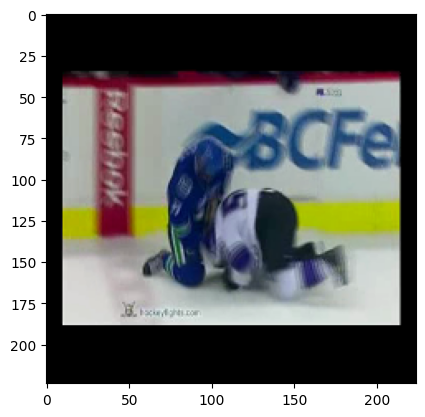

In [22]:
plt.imshow(visible_frame[3])


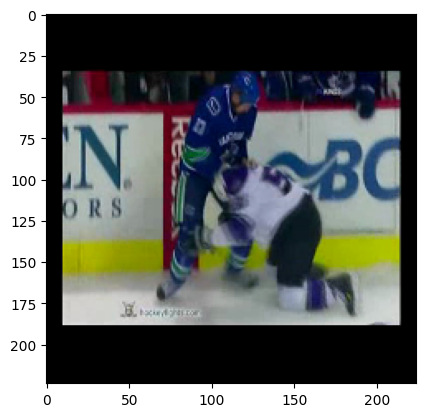

In [23]:
plt.imshow(visible_frame[15])


# Pre-Trained Model: VGG16

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded which is about 528 MB

weights=‘imagenet’: This indicates that the model should use the weights that were pre-trained on the ImageNet dataset. The ImageNet dataset contains millions of labeled images across thousands of categories, making it a comprehensive resource for training robust image classification models.

In [144]:


image_model = VGG16(include_top=True, weights='imagenet')


Here is the model summary

In [145]:
image_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

As we can see that the input size must be (224,224,3) that as we specified at the Data dimension section

In [26]:
input_shape = image_model.input_shape[1:3]
input_shape

(224, 224)

# The VGG16 model flowchart

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 20 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.

The reason for using a cache-file is that it takes a long time to process an image with the VGG16 model. If each image is processed more than once then we can save a lot of time by caching the transfer-values.

When all the videos have been processed through the VGG16 model and the resulting transfer-values saved to a cache file, then we can use those transfer-values as the input to LSTM neural network. We will then train the second neural network using the classes from the violence dataset (Violence, No-Violence), so the network learns how to classify images based on the transfer-values from the VGG16 model.

In [27]:
from tensorflow.keras import backend as K
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


A function to proccess a 20 frames from a video through the pretrained VGG16 model and return the transfered values

In [28]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

A function that generates each video through VGG16 model

In [29]:
def proces_transfer(vid_names, in_dir, labels):
    
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1
    

A function to save the transfered Values for later use 

In [30]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba1.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            print_progress(numer, n_files)
        
            numer += 1

In [31]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation1.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            print_progress(numer, n_files)
        
            numer += 1

# Splitting the dataset into training and testing

In [32]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]


Here we are going to proccess all of the frames of the videos through the VGG16 model and then saving the transfered values into the disk

In [33]:
make_files(training_set)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


2024-05-22 15:09:21.653573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [34]:
make_files_test(test_set)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

In [35]:
test_set

200

In [36]:
training_set

800

In [1]:
'''
Reimporting the libraries for easier Access

%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
'''

# Loading the cached transfer values into the memory

We have already saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net.

In [2]:

def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba1.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target
     

In [3]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation1.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [4]:
data, target = process_alldata_training()



In [5]:
data_test, target_test = process_alldata_test()


# Defining the LSTM model

LSTM is an advanced Type of RNN designed to handle long-term dependencies more effectively.

Define LSTM architecture:

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 20 frames so we will have 20 x 4096 values per video. The classification must be done taking into account the 20 frames of the video. If any of them detects violence, the video will be classified as violent.

In [114]:

chunk_size = 4096 # The size of each chunk of data (the size of each frame)

n_chunks = 20 # This defines the number of chunks in the sequence (20 frames)

rnn_size = 265 # This is the number of units (neurons) in the LSTM layer.

model5 = Sequential() # Initialize the sequential model

# LSTM layer with 'rnn_size' units. The input shape is (n_chunks, chunk_size)
model5.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))

# This helps to stabilize and accelerate the training process and Provides a regularizing effect
model5.add(BatchNormalization())

# This helps to prevent overfitting by randomly shutting down some neurons by 50%
model5.add(Dropout(0.5))

model5.add(Dense(2048))# Fully connected layer with 2048 units(neuron)

model5.add(BatchNormalization())# Add batch normalization layer

model5.add(Activation('sigmoid'))# Sigmoid activation function for non-linearity

model5.add(Dropout(0.3))# Dropping neurons by 30%

model5.add(Dense(64))# Fully connected layer with 64 units(neuron)

model5.add(Activation('sigmoid'))# Sigmoid activation function for non-linearity

model5.add(Dropout(0.2))# Dropping neurons by 20%

model5.add(Dense(2))# Fully connected layer with 2 units(neuron) for binary classification

model5.add(Activation('sigmoid'))

learning_rate = 0.000005  # learning rate for the optimizer

optimizer = Adam(learning_rate=learning_rate)# Adam optimizer with the specified learning rate

# Compile the model with binary cross-entropy loss and Adam optimizer
model5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Stop training when the loss has stopped improving for 7 epochs
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor = "loss", patience = 7, restore_best_weights= True)

# Reduce learning rate when the validation loss has stopped improving for 2 epochs
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.6, patience = 2,
    min_lr = 0.0000005, verbose = 1)

/Users/salemnsour/Desktop/CV/CV/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Model training

In [115]:
epoch = 100
batchS = 64

history5 = model5.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch, 
                    batch_size=batchS,validation_data=(np.array(data[750:]),np.array(target[750:])),
                      callbacks = [early_stopping_callback,reduce_lr_callback])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.5108 - loss: 0.7406 - val_accuracy: 0.5000 - val_loss: 0.7415 - learning_rate: 5.0000e-06
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5191 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.7284 - learning_rate: 5.0000e-06
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5744 - loss: 0.6511 - val_accuracy: 0.5000 - val_loss: 0.7177 - learning_rate: 5.0000e-06
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6209 - loss: 0.6313 - val_accuracy: 0.5000 - val_loss: 0.7077 - learning_rate: 5.0000e-06
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6324 - loss: 0.6140 - val_accuracy: 0.5000 - val_loss: 0.6978 - learning_rate: 5.0000e-06
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7128 - loss: 0.5746 - val_accuracy: 0.5000 - val_loss: 0.6892 - learning_rate: 5.0000e-06
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy:

Epoch 44/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9273 - loss: 0.2989 - val_accuracy: 0.8800 - val_loss: 0.3385 - learning_rate: 5.0000e-06
Epoch 45/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9227 - loss: 0.2939 - val_accuracy: 0.9000 - val_loss: 0.3306 - learning_rate: 5.0000e-06
Epoch 46/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9436 - loss: 0.2694 - val_accuracy: 0.9000 - val_loss: 0.3209 - learning_rate: 5.0000e-06
Epoch 47/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9412 - loss: 0.2767 - val_accuracy: 0.9000 - val_loss: 0.3232 - learning_rate: 5.0000e-06
Epoch 48/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9340 - loss: 0.2814 - val_accuracy: 0.9000 - val_loss: 0.3163 - learning_rate: 5.0000e-06
Epoch 49/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9349 - loss: 0.2820 - val_accuracy: 0.9000 - val_loss: 0.3181 - learning_rate: 5.0000e-06
Epoch 50/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc

Epoch 83/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9470 - loss: 0.2471 - val_accuracy: 0.9000 - val_loss: 0.2871 - learning_rate: 5.0000e-07
Epoch 84/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9512 - loss: 0.2224 - val_accuracy: 0.9000 - val_loss: 0.2868 - learning_rate: 5.0000e-07
Epoch 85/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9421 - loss: 0.2370 - val_accuracy: 0.9000 - val_loss: 0.2870 - learning_rate: 5.0000e-07
Epoch 86/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9476 - loss: 0.2346 - val_accuracy: 0.9000 - val_loss: 0.2872 - learning_rate: 5.0000e-07


# Model testing an evaluating

We are here testing the performance of the model by sevral metrics , and we have assured the test set have not been seen by the model

In [122]:
result = model5.evaluate(np.array(data_test), np.array(target_test))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9401 - loss: 0.2121


In [147]:
from sklearn.metrics import classification_report 
print("Classification Report:")
print(classification_report(target_test, y_pred, target_names=['NonViolence', 'Violence']))

Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.95      0.96      0.96       111
    Violence       0.95      0.93      0.94        89

   micro avg       0.95      0.95      0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200
 samples avg       0.95      0.95      0.95       200



In [148]:
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix

# Get the predictions for your test data
y_pred = model5.predict(np.array(data_test))

y_pred = (y_pred > 0.5).astype("int32")
# Calculate the confusion matrix
mcm = multilabel_confusion_matrix(target_test, y_pred)

print("Confusion Matrix:")
print(mcm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix:
[[[ 83   6]
  [  4 107]]

 [[107   4]
  [  6  83]]]


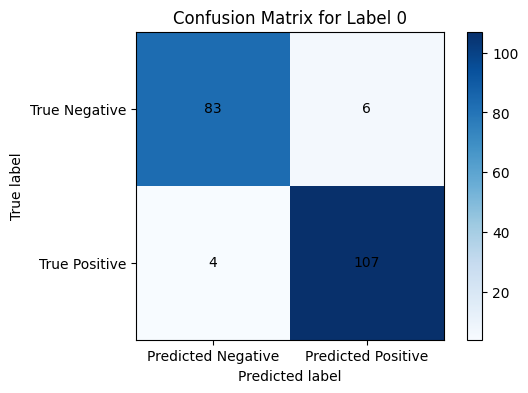

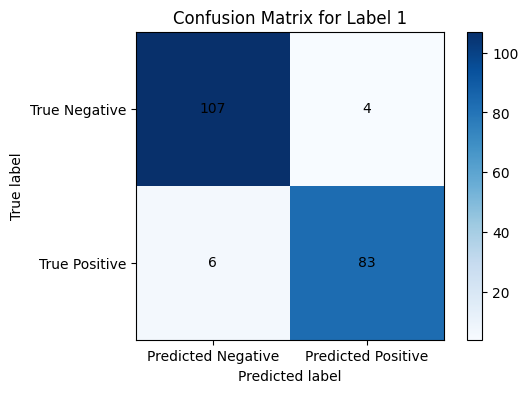

In [149]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the confusion matrix for each label
for i, cm in enumerate(mcm):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
    plt.yticks([0, 1], ['True Negative', 'True Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for Label {i}')
    
    # Add text annotations
    for y in range(cm.shape[0]):
        for x in range(cm.shape[1]):
            plt.text(x, y, f'{cm[y, x]}', ha='center', va='center', color='black')
    
    plt.show()

# Showing the accuracy and loss over epochs  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


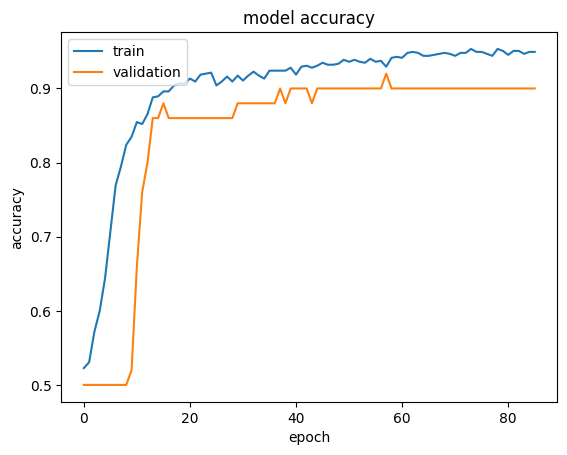

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


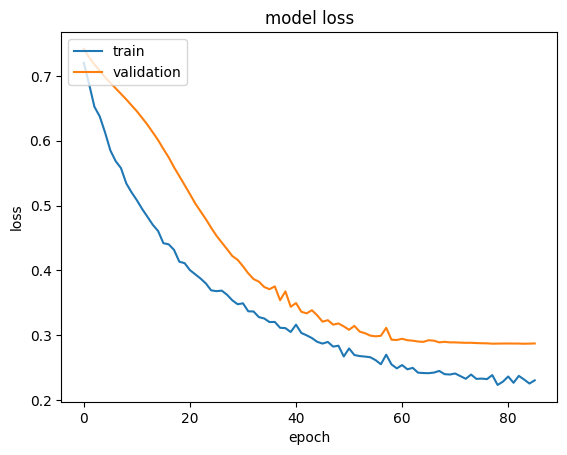

In [117]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

# summarize history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

# Saving the best weights for the model

We are saving the Weights so w dont have to Train the model further

In [139]:
weights_path = 'best_weights1.h5'
with h5py.File(weights_path, 'w') as f:
    for layer in model5.layers:
        g = f.create_group(layer.name)
        weights = layer.get_weights()
        for i, weight in enumerate(weights):
            g.create_dataset(f"weight_{i}", data=weight)

print(f"Model weights saved to: {weights_path}")




Model weights saved to: best_weights1.h5


In [137]:
with h5py.File(weights_path, 'r') as f:
    for layer in model5.layers:
        weights = [f[layer.name][f"weight_{i}"][:] for i in range(len(f[layer.name]))]
        layer.set_weights(weights)